In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

# Day10: 圖像處理功能整合工具

In [27]:
def show_rgb_img(img):
    output_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(output_img)
    plt.show()

In [28]:
def brightness(img,light):
    
    #利用公式進行亮度調整
    org_img = img
    maxIntensity = 255
    phi = 1
    theta = 1
      
    #調整亮度
    output_img = (maxIntensity/phi)*(org_img/(maxIntensity/theta))**light
    output_img = np.array(output_img, dtype=np.uint8)

    # 
    show_rgb_img(output_img)

In [29]:
def saturation(img):
    
    #將RGB轉換為HLS以進行飽和度調整
    org_img = img

    #進行歸一化(讓值介於0和1之間)
    float_img = org_img.astype(np.float32)
    float_img = float_img/255

    #BGR to HLS
    HLS_img = cv2.cvtColor(float_img, cv2.COLOR_BGR2HLS)
    copy_HLS_img = np.copy(HLS_img) #copy:修改HLS_img內容並不會影響copy_HLS_img

    lightness = 0 #亮度
    saturation = 300 #飽和度

    [x,y,z] = copy_HLS_img.shape
    #亮度
    copy_HLS_img[:, :, 1] = (1 + lightness / 100.0) * copy_HLS_img[:, :, 1]

    for i in range(0, x):
        for j in range(0,y):
            if copy_HLS_img[i, j, 1]>1:
                copy_HLS_img[i, j, 1] = 1 #移除亮度大於1的數

    #飽和度
    copy_HLS_img[:, :, 2] = (1 + saturation / 100.0) * copy_HLS_img[:, :, 2]

    for i in range(0, x):
        for j in range(0,y):
            if copy_HLS_img[i, j, 2]>1:
                copy_HLS_img[i, j, 2] = 1 #移除飽和度大於1的數


    #HLS to BGR
    output_img = cv2.cvtColor(copy_HLS_img, cv2.COLOR_HLS2BGR)
    output_img = ((output_img * 255).astype(np.uint8))
    
    # 
    show_rgb_img(output_img)

In [32]:
def tones(img,tone):
    #分別取出B、G、R值分別做冷熱色調的調整
    org_img = img
    val = 50
    
    #1:冷色調、2:暖色調
    if tone==1:
        b_val = 0
        g_val = val
        r_val = val
    elif tone == 2:
        b_val = val
        g_val = val
        r_val = 0 
    else:
        b_val = 0
        g_val = 0
        r_val = 0        

    imgB = org_img[:,:,0]
    imgG = org_img[:,:,1]
    imgR = org_img[:,:,2]

    #冷色調
    bAvg = cv2.mean(imgB)[0]+b_val #mean()[0]:取第0個通道的值 (因為輸出型態是1*4的矩陣)
    gAvg = cv2.mean(imgG)[0]+g_val
    rAvg = cv2.mean(imgR)[0]+r_val
    avgGray = int(bAvg+gAvg+rAvg)/3 #float to int

    #計算增益係數
    b_coe = avgGray/bAvg
    g_coe = avgGray/gAvg
    r_coe = avgGray/rAvg
    imgB = np.floor(imgB*b_coe)
    imgG = np.floor(imgG*g_coe)
    imgR = np.floor(imgR*r_coe)

    #移除大於255的數值
    [x,y,z] = org_img.shape
    for i in range(0,x):
        for j in range(0,y):
            if imgB[i,j]>255:
                imgB[i,j]=255
            if imgR[i,j]>255:
                imgR[i,j]=255
            if imgG[i,j]>255:
                imgG[i,j]=255

    output_img = np.dstack((imgB,imgG,imgR)).astype(np.uint8)
    
    # 
    show_rgb_img(output_img)


In [40]:
def grainy(img):
    org_img = img

    #歸一化
    org_img = org_img/255

    #隨機生成高斯雜訊(常態分布)
    mean = 0 #平均
    deviation = 0.5 #標準差
    noise = np.random.normal(mean, deviation, org_img.shape)

    guss_src = org_img + noise #原圖套上雜訊遮罩
    guss_src = np.clip(guss_src, 0, 1) #np.cilp:限制矩陣中的數值介於0和1之間，>1:=1,<0:=0
    output_img = np.uint8(guss_src*255)
    
    # 
    show_rgb_img(output_img)

In [41]:
def contrast(img,contr):
    #利用公式計算出對比度
    org_img = img

    bright = 0

    B = bright/255
    C = contr/255
    k = math.tan((45+44*C)/180*math.pi) #math function

    contract_img = (org_img-127.5*(1-B)*k+127.5*(1+B))
    output_img = np.clip(contract_img, 0, 255).astype(np.uint8) #np.cilp:限制矩陣中的數值介於0和1之間，>255:=255,<0:=0
    
    # 
    show_rgb_img(output_img)

In [45]:
def blur_highlights(img):
    org_img = img
    gray_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2GRAY) #轉灰階圖像
    ret, thres_img = cv2.threshold(gray_img, 127, 255, 0) #利用threshold過濾出高光部分

    counters,hierarchy = cv2.findContours(thres_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #找出含有高光的輪廓

    #將list儲存的高光區域以座標位置儲存在圖像上
    hi_img =  np.zeros(src.shape, dtype=np.uint8) 
    for count in counters:
        x,y,w,h = cv2.boundingRect(count)
        hi_img[y:y+h,x:x+w] = 255
        mask = hi_img

    #模糊高光
    output_img = cv2.illuminationChange(org_img, mask, alpha=0.2, beta=0.2) 
    
    #
    show_rgb_img(output_img)

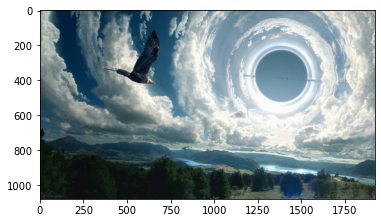

1.亮度
2.飽和度
3.冷暖色調
4.顆粒感
5.對比度
6.模糊高光
---------------
請選擇處理項目:8
錯誤


In [49]:
src = cv2.imread('C:\\Users\\USER\\Pictures\\Wallpaper\\thumb-1920-946628.png') #絕對路徑使用'\'，相對路徑使用'/'

#opencv格式為BGR，所以要轉成RGB顯示
rgbsrc = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
plt.imshow(rgbsrc)
plt.show()

print("1.亮度")
print("2.飽和度")
print("3.冷暖色調")
print("4.顆粒感")
print("5.對比度")
print("6.模糊高光")
print("---------------")

select = input("請選擇處理項目:")
select = int(select)

if select == 1:
    light = input("請輸入亮度係數(ex:0.5、2):")
    light = float(light)
    brightness(src,light)
elif select == 2:
    saturation(src)
elif select == 3:
    tone = input("請選擇冷暖色調(1:冷色調、2:暖色調):")
    tone = int(tone)
    tones(src,tone)
elif select == 4:
    grainy(src)
elif select == 5:
    contr = input("請輸入對比係數(ex:-100、100):")
    contr = int(contr)
    contrast(src,contr)
elif select == 6:
    blur_highlights(src)
else:
    print("錯誤")